In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from scipy import integrate
from scipy.optimize import brentq, fsolve, minimize_scalar, curve_fit
from scipy.stats import norm, multivariate_normal

In [2]:
# Parameters (WTI Sep '23 (CLU23) on July 07 2023)
futures_price = 73.77
strike_price = 73.0
risk_free_rate = 0.05235
time_to_maturity = 40/365
vol_black = 0.32
vol_bachelier = vol_black*futures_price

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Bachelier (1900)
\begin{align*}
& dF_t = \sigma_a dW_t \\\\
& C_{BC}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [(F-K)N(m_a) + \sigma_a\sqrt{\tau}n(m_a)] \\
& P_{BC}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [(K-F)(1-N(m_a)) + \sigma_a\sqrt{\tau}n(m_a)] \\\\
&\textit{ where} \\
&\ m_a = \frac{F-K}{\sigma_a \sqrt{\tau}}
\end{align*}

In [4]:
# Bachelier (1900)
class Bachelier:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K , vol = None, option_type = 'call'):
      '''
      Bachelier formula
      return call/put option price
      '''
      # default parameter
      if vol == None:
        vol = self.vol

      m = (self.F - K) / (vol * self.tau**0.5)
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ((self.F - K) * norm.cdf(m) + vol * self.tau**0.5 * norm.pdf(m))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ((K - self.F) * (1 - norm.cdf(m)) + vol * self.tau**0.5 * norm.pdf(m))


    def simulate_F(self, paths = 100000, steps = 2):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''

      # initialize vectors
      arr_F = np.zeros((paths, steps))
      arr_F[:,0] = self.F

      # generate Brownian motion
      arr_w = np.random.standard_normal(size = (paths, steps-1))

      # compute the corresponding price
      t_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0, steps-1):
        arr_F[:,t+1] = arr_F[:,t] + self.vol * dt**0.5 * arr_w[:,t]

      return arr_F, t_vec

In [5]:
bachelier = Bachelier(futures_price, vol_bachelier, risk_free_rate, time_to_maturity)
bachelier_call = bachelier.option_pricer(K = strike_price, option_type = 'call')
bachelier_put = bachelier.option_pricer(K = strike_price, option_type = 'put')

print(f'Bachelier formula:')
print(f'call is {bachelier_call:.4f}')
print(f'put is {bachelier_put:.4f}')

Bachelier formula:
call is 3.4976
put is 2.7320


In [6]:
# verify through Monte Carlo simulation
paths = 1000000
arr_F, _ = bachelier.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
mean_call, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
mean_put, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation:')
print(f'call is {mean_call:.4f} with standard error {ste_call:.6f}')
print(f'put is {mean_put:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation:
call is 3.4964 with standard error 0.004795
put is 2.7342 with standard error 0.004276


## Black (1976)
\begin{align*}
& dF_t = \sigma_G F_tdW_t \\\\
& C_{BL}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [FN(m_G + \frac{\sigma_G\sqrt{\tau}}{2}) - KN(m_G - \frac{\sigma_G\sqrt{\tau}}{2})] \\
& P_{BL}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [K(1-N(m_G - \frac{\sigma_G\sqrt{\tau}}{2})) - F(1-N(m_G + \frac{\sigma_G\sqrt{\tau}}{2}))] \\\\
& \textit{ where} \\
&\ m_G = \frac{ln(F-K)}{\sigma_a \sqrt{\tau}}
\end{align*}

In [7]:
# Black (1976)
class Black:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K, vol = None, option_type = 'call'):
      '''
      Black formula
      return call/put option price
      '''
      # default parameter
      if vol == None:
        vol = self.vol

      m = np.log(self.F / K) / (vol * self.tau**0.5)
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ( self.F * norm.cdf(m + 0.5*vol*self.tau**0.5) -
                                                    K * norm.cdf(m - 0.5*vol*self.tau**0.5))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ( K * (1 - norm.cdf(m - 0.5*vol*self.tau**0.5)) -
                                                    self.F * (1 - norm.cdf(m + 0.5*vol*self.tau**0.5)))


    def simulate_F(self, paths = 100000, steps = 2):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''

      # initialize vectors
      arr_F = np.zeros((paths, steps))
      arr_F[:,0] = self.F

      # generate Brownian motion
      arr_w = np.random.standard_normal(size = (paths, steps-1))

      # compute the corresponding price
      t_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0, steps-1):
        arr_F[:,t+1] = arr_F[:,t] * np.exp( -0.5 * self.vol**2 * dt + self.vol * dt**0.5 * arr_w[:,t] )

      return arr_F, t_vec

In [8]:
black = Black(futures_price, vol_black, risk_free_rate, time_to_maturity)
black_call = black.option_pricer(K = strike_price, option_type = 'call')
black_put = black.option_pricer(K = strike_price, option_type = 'put')

print(f'Black formula:')
print(f'call is {black_call:.4f}')
print(f'put is {black_put:.4f}')

Black formula:
call is 3.4801
put is 2.7145


In [9]:
# verify through Monte Carlo simulation
paths = 1000000
arr_F, _ = black.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
mean_call, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
mean_put, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation:')
print(f'call is {mean_call:.4f} with standard error {ste_call:.6f}')
print(f'put is {mean_put:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation:
call is 3.4786 with standard error 0.005082
put is 2.7116 with standard error 0.003997


## Heston (1993)
\begin{cases}
dF_t = \sqrt{v_t} F_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^2_t\\
dW^1_tdW^2_t = \rho dt
\end{cases}

In [10]:
# Heston (1993)

def cf(u, tau, mu, rho, v0, theta, kappa, sigma):

    """
    Heston characteristic function in Schoutens (2004)
    """

    d = ((kappa - rho*sigma*u*1j)**2 + sigma**2*(1j*u + u**2))**0.5
    g = (kappa - rho*sigma*u*1j - d)/(kappa - rho*sigma*u*1j + d)
    cf_ = np.exp( 1j*u*mu*tau +
                 theta*kappa*sigma**-2*((kappa - rho*sigma*u*1j - d)*tau - 2*np.log((1 - g*np.exp(-d*tau))/( 1 - g))) +
                 v0*sigma**-2*(kappa - rho*sigma*u*1j - d)*(1 - np.exp(-d*tau))/(1 - g*np.exp(-d*tau)) )
    return cf_

class Heston:
    def __init__(self, F, v0, theta, kappa, sigma, rho,  r, tau):
      self.F = F
      self.v0 = v0 # spot variance
      self.theta = theta
      self.kappa = kappa
      self.sigma = sigma
      self.rho = rho
      self.r = r
      self.tau = tau
      if 2*kappa * theta < sigma**2:
        print(f'Warning: Feller condition fails')


    def option_pricer(self, K, option_type = 'call'):
      '''
      Fourier inversion
      return call/put option price
      '''
      k = np.log(K/self.F)
      cf_ = partial(cf, tau = self.tau, mu = 0, rho = self.rho, v0 = self.v0,
                    theta = self.theta, kappa = self.kappa, sigma = self.sigma )

      integrand_Q1 = lambda u: np.real((np.exp(-u*k*1j) * cf_(u-1j) / (u*1j)) / cf_(-1j))
      integrand_Q2 = lambda u: np.real(np.exp(-u*k*1j) * cf_(u) / (u*1j))

      Q1 = 1/2 + 1/np.pi * integrate.quad(integrand_Q1, 1e-15, np.inf, limit=2000)[0]
      Q2 = 1/2 + 1/np.pi * integrate.quad(integrand_Q2, 1e-15, np.inf, limit=2000)[0]

      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ( self.F * Q1 - K * Q2)
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ( K * (1-Q2) - self.F * (1-Q1) )


    def simulate_F(self, paths = 10000, steps = None):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''

      # default parameter
      if steps == None:
        steps = int(self.tau*252*10)

      # Initialize vectors
      arr_F = np.zeros((paths,steps)); arr_F[:,0] = self.F
      arr_v = np.zeros((paths,steps)); arr_v[:,0] = self.v0

      # Generate 2D Brownian motions
      arr_w = multivariate_normal.rvs( mean = np.array([0, 0]),
                                        cov = np.array([[1, self.rho], [self.rho, 1]]),
                                        size = (paths, steps-1) )

      # Compute the corresponding paths
      t_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0,steps-1):
        arr_F[:,t+1] = arr_F[:,t] + arr_F[:,t] * ( arr_v[:,t] * dt )**0.5 * arr_w[:,t,0]
        arr_v[:,t+1] = arr_v[:,t] + self.kappa * ( self.theta - arr_v[:,t] ) * dt + self.sigma * ( arr_v[:,t] * dt )**0.5 * arr_w[:,t,1]
        arr_v[arr_v[:,t+1] < 0.0, t+1] = 1e-5 # prevent negative variance

      return arr_F, t_vec

In [11]:
# Heston parameters
rho = -0.30                                         # correlation coefficient
v0 = 0.30**2                                        # spot variance
theta = 0.40**2                                     # long-term variance
kappa = 5.0                                         # mean reversion coefficient
sigma = 0.7                                         # volatility of instantaneous variance (Vol of Vol)

In [12]:
heston = Heston(futures_price, v0, theta, kappa, sigma, rho, risk_free_rate, time_to_maturity)
heston_call = heston.option_pricer(K = strike_price, option_type = 'call')
heston_put = heston.option_pricer(K = strike_price, option_type = 'put')

print(f'Fourier inversion formula:')
print(f'call is {heston_call:.4f}')
print(f'put is {heston_put:.4f}')

Fourier inversion formula:
call is 3.5003
put is 2.7348


In [13]:
# verify through Monte Carlo simulation
paths = 100000
arr_F, _ = heston.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
mean_call, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
mean_put, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation:')
print(f'call is {mean_call:.4f} with standard error {ste_call:.6f}')
print(f'put is {mean_put:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation:
call is 3.5074 with standard error 0.015641
put is 2.7336 with standard error 0.013548


## Quadratic Normal Model (Bouchouev, 2023)

\begin{align*}
&\begin{cases}
dF_t = \sigma(F_t)dW_t \\
\sigma(F_t) = a + \epsilon(F) = a + bF + c F^2
\end{cases}\\\\
&C(F, K, a, b, c, r,\tau) = C_{BC}(F, K, \sigma_a = a, r,\tau) + e^{-r\tau}U\\
&P(F, K, a, b, c, r,\tau) = P_{BC}(F, K, \sigma_a = a, r,\tau) + e^{-r\tau}U\\\\  
& \textit{where}\\
&\ C_{BC}: \textit{Bachelier call formula}\\
&\ P_{BC}: \textit{Bachelier put formula}\\
&\ U = \sqrt{\tau}n(\frac{F-K}{a\sqrt{\tau}})[\frac{b}{2}(F+K) + \frac{c}{3}(F^2+FK+K^2+\frac{a^2\tau}{2})]
\end{align*}

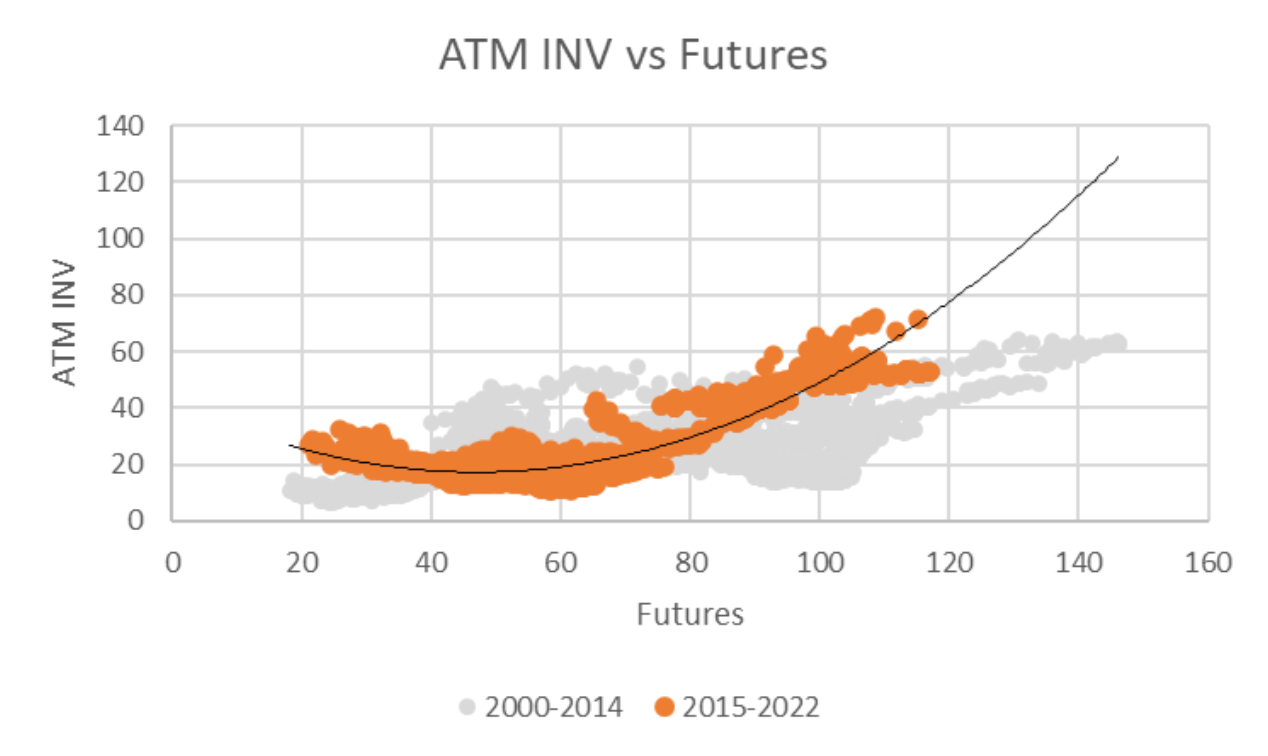

$\sigma(F) = a + bF + cF^2= a - \frac{b^2}{4c} + c(F-\frac{-b}{2c})^2$

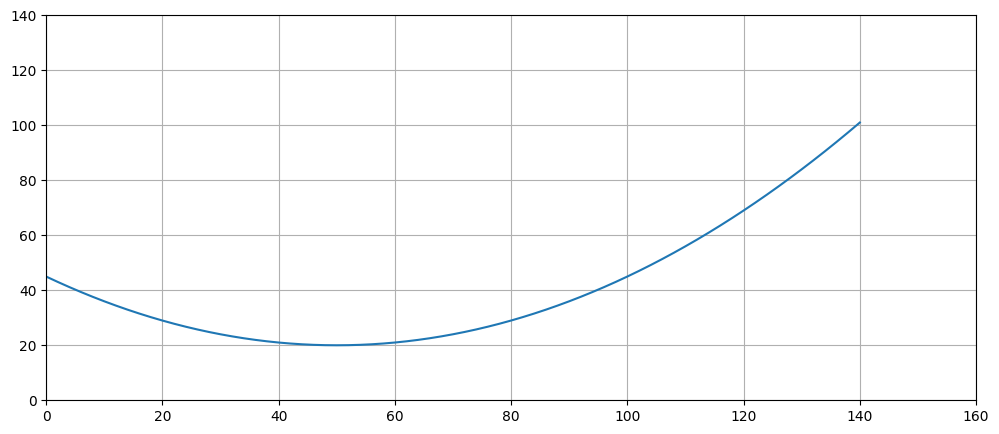

In [14]:
# calibrate parameters a, b, c on historical data (base case)
sigma_qnm = lambda f : 0.01*(f-50)**2 + 20
arr_f = np.arange(0,141,2)

plt.figure(figsize=(12,5))
plt.plot(arr_f, sigma_qnm(arr_f))

plt.xlim(0,160)
plt.ylim(0,140)
plt.grid()

plt.show()

In [15]:
# parameters
c = 0.01
b = -50 * 2 * c
a = 20 + b**2/4/c

In [16]:
# Quadratic Normal Model (2023)
class QNM:
    def __init__(self, F, a, b, c, r, tau):
      self.F = F
      self.a = a
      self.b = b
      self.c = c
      self.r = r
      self.tau = tau


    def option_pricer(self, K, option_type = 'call'):
      '''
      The method of linearization
      return call/put option price
      '''
      m = (self.F - K)/(self.a * self.tau**0.5)
      C_BC = np.exp(-self.r * self.tau) * ((self.F - K)*norm.cdf(m) + self.a * self.tau**0.5 * norm.pdf(m))
      P_BC = np.exp(-self.r * self.tau) * ((K - self.F)*(1-norm.cdf(m)) + self.a * self.tau**0.5 * norm.pdf(m))
      U = self.tau**0.5 * norm.pdf(m) * (self.b*(self.F + K)/2 +
                            self.c*(self.F**2 + self.F*K + K**2 + 0.5*self.a**2*self.tau)/3)

      if option_type == 'call':
        return C_BC + U*np.exp(-self.r * self.tau)
      elif option_type == 'put':
        return P_BC + U*np.exp(-self.r * self.tau)


    def simulate_F(self, paths = 10000, steps = None):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''

      # default parameter
      if steps == None:
        steps = int(self.tau*252*10)

      # Initialize vectors
      arr_F = np.zeros((paths,steps))
      arr_F[:,0] = self.F

      # generate Brownian motion
      arr_w = np.random.standard_normal(size = (paths, steps-1))

      # compute the corresponding price
      t_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      vol_ = lambda f : self.a + self.b*f + self.c*f**2
      for t in range(0, steps-1):
        arr_F[:,t+1] = arr_F[:,t] + vol_(arr_F[:,t]) * dt**0.5 * arr_w[:,t]

      return arr_F, t_vec

In [17]:
qnm = QNM(futures_price, a, b, c, risk_free_rate, time_to_maturity)
qnm_call = qnm.option_pricer(K = strike_price, option_type = 'call')
qnm_put = qnm.option_pricer(K = strike_price, option_type = 'put')

print(f'The method of linearization:')
print(f'call is {qnm_call:.4f}')
print(f'put is {qnm_put:.4f}')

The method of linearization:
call is 3.7870
put is 3.0214


In [18]:
# verify through Monte Carlo simulation
paths = 100000
arr_F, _ = qnm.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
mean_call, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
mean_put, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation:')
print(f'call is {mean_call:.4f} with standard error {ste_call:.6f}')
print(f'put is {mean_put:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation:
call is 3.7491 with standard error 0.018323
put is 3.0196 with standard error 0.013715


## Option Prices across Models

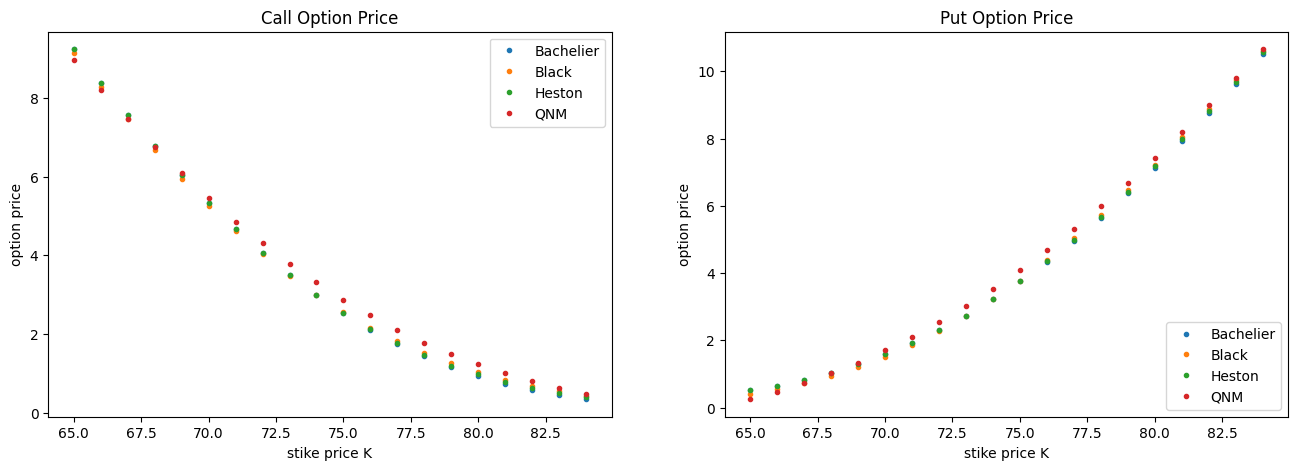

In [19]:
arr_strike = np.arange(65,85,1)

# call option
arr_bachelier_call = bachelier.option_pricer(K = arr_strike, option_type = 'call')
arr_black_call = black.option_pricer(K = arr_strike, option_type = 'call')
list_heston_call = []
for strike_ in arr_strike:
  list_heston_call.append(heston.option_pricer(K = strike_, option_type = 'call'))
arr_qnm_call = qnm.option_pricer(K = arr_strike, option_type = 'call')

# put option
arr_bachelier_put = bachelier.option_pricer(K = arr_strike, option_type = 'put')
arr_black_put = black.option_pricer(K = arr_strike, option_type = 'put')
list_heston_put = []
for strike_ in arr_strike:
  list_heston_put.append(heston.option_pricer(K = strike_, option_type = 'put'))
arr_qnm_put = qnm.option_pricer(K = arr_strike, option_type = 'put')

# create subplots
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(arr_strike, arr_bachelier_call, '.', linewidth = 0.5, label = 'Bachelier')
ax1.plot(arr_strike, arr_black_call, '.', linewidth = 0.5, label = 'Black')
ax1.plot(arr_strike, list_heston_call, '.', linewidth = 0.5, label = 'Heston')
ax1.plot(arr_strike, arr_qnm_call, '.', linewidth = 0.5, label = 'QNM')
ax1.set_title('Call Option Price')
ax1.set_xlabel('stike price K')
ax1.set_ylabel('option price')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(122)
ax2.plot(arr_strike, arr_bachelier_put, '.', linewidth = 0.5, label = 'Bachelier')
ax2.plot(arr_strike, arr_black_put, '.', linewidth = 0.5, label = 'Black')
ax2.plot(arr_strike, list_heston_put, '.', linewidth = 0.5, label = 'Heston')
ax2.plot(arr_strike, arr_qnm_put, '.', linewidth = 0.5, label = 'QNM')
ax2.set_title('Put Option Price')
ax2.set_xlabel('stike price K')
ax2.set_ylabel('option price')
ax2.legend(loc='lower right')

plt.show()

## Implied Volatility

In [20]:
def implied_volatility(option_price, F, K, r, tau, option_type = 'call', model = 'black', method='brent', disp=True):
    """
        Return Implied volatility
        model: black (default), bachelier
        methods: brent (default), fsolve, minimization
    """
    # model
    if model == 'bachelier':
      bachelier_ = Bachelier(F, F*0.1, r, tau)
      obj_fun = lambda vol : option_price - bachelier_.option_pricer(K = K, vol = vol, option_type = option_type)
    else: # model == 'black'
      black_ = Black(F, 0.1, r, tau)
      obj_fun = lambda vol : option_price - black_.option_pricer(K = K, vol = vol, option_type = option_type)

    # numerical method
    if method == 'minimization':
      obj_square = lambda vol : obj_fun(vol)**2
      res = minimize_scalar( obj_square, bounds=(1e-15, 8), method='bounded')
      if res.success == True:
        return res.x

    elif method == 'fsolve':
        X0 = [0.1, 0.5, 1, 3]   # set of initial guess points
        for x0 in X0:
            x, _, solved, _ = fsolve(obj_fun, x0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    else:
        x, r = brentq( obj_fun, a = 1e-15, b = 500, full_output = True)
        if r.converged == True:
            return x


    # display strikes with failed convergence
    if disp == True:
        print(method, K)
    return -1

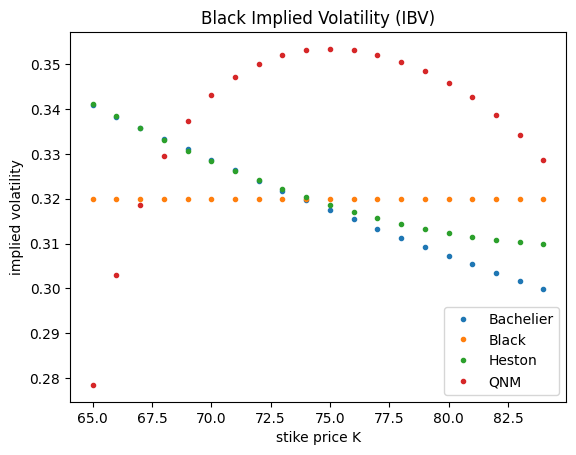

In [21]:
# Black implied volatility (IBV)
list_ibv_bachelier, list_ibv_black, list_ibv_heston, list_ibv_qnm = [], [], [], []
for stirke_, bachelier_, black_, heston_, qnm_ in zip(arr_strike, arr_bachelier_call, arr_black_call, list_heston_call, arr_qnm_call):
  list_ibv_bachelier.append(implied_volatility(bachelier_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))
  list_ibv_black.append(implied_volatility(black_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))
  list_ibv_heston.append(implied_volatility(heston_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))
  list_ibv_qnm.append(implied_volatility(qnm_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))

# create plot
plt.plot(arr_strike, list_ibv_bachelier, '.', label = 'Bachelier')
plt.plot(arr_strike, list_ibv_black, '.', label = 'Black')
plt.plot(arr_strike, list_ibv_heston, '.', label = 'Heston')
plt.plot(arr_strike, list_ibv_qnm, '.', label = 'QNM')
plt.title('Black Implied Volatility (IBV)')
plt.xlabel('stike price K')
plt.ylabel('implied volatility')
plt.legend(loc = 'lower right')
plt.show()

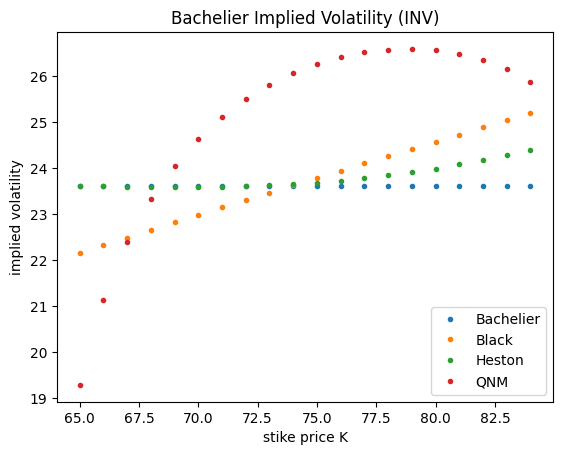

In [22]:
# Bachelier implied volatility (INV)
list_inv_bachelier, list_inv_black, list_inv_heston, list_inv_qnm = [], [], [], []
for stirke_, bachelier_, black_, heston_, qnm_ in zip(arr_strike, arr_bachelier_call, arr_black_call, list_heston_call, arr_qnm_call):
  list_inv_bachelier.append(implied_volatility(bachelier_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))
  list_inv_black.append(implied_volatility(black_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))
  list_inv_heston.append(implied_volatility(heston_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))
  list_inv_qnm.append(implied_volatility(qnm_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))


plt.plot(arr_strike, list_inv_bachelier, '.', label = 'Bachelier')
plt.plot(arr_strike, list_inv_black, '.', label = 'Black')
plt.plot(arr_strike, list_inv_heston, '.', label = 'Heston')
plt.plot(arr_strike, list_inv_qnm, '.', label = 'QNM')
plt.title('Bachelier Implied Volatility (INV)')
plt.xlabel('stike price K')
plt.ylabel('implied volatility')
plt.legend(loc = 'lower right')
plt.show()

## QNM Model Calibration

In [23]:
# July 07 2023
# Options on WTI Sep '23 (CLU23)
# downloaded from Bartchart.com

In [24]:
# Read CSV file from Google Drive
filename = '/content/gdrive/MyDrive/job preparation/data/' +\
              'clu23-options-07-07-2023.csv'
df_raw_data = pd.read_csv(filename, header=0, index_col = 5)
df_raw_data = df_raw_data.iloc[:-1]
df_raw_data.head()

,Type,Last,Volume,Open Int,Daily Premium,Type.1,Last.1,Volume.1,Open Int.1,Daily Premium.1
Strike,,,,,,,,,,
49.0,Call,24.77,NaN,4.0,24770.0,Put,0.04,18.0,877.0,40.00
49.5,Call,24.27,1.0,1.0,24270.0,Put,0.05,NaN,557.0,50.00
50.0,Call,23.77,346.0,804.0,23770.0,Put,0.05,115.0,4225.0,50.00
50.5,Call,23.28,1.0,157.0,23280.0,Put,0.05,NaN,438.0,50.00
51.0,Call,22.78,NaN,689.0,22780.0,Put,0.06,11.0,749.0,60.00


In [25]:
# OTM options with high trading volume (>100) to compute implied vol
list_data = []
for index_ in df_raw_data.index:
  if index_ < futures_price:
    if df_raw_data.loc[index_, 'Volume.1'] > 100:
      list_data.append((index_, df_raw_data.loc[index_, 'Last.1'], 'put'))
  else:
    if df_raw_data.loc[index_, 'Volume'] > 100:
      list_data.append((index_, df_raw_data.loc[index_, 'Last'], 'call'))

arr_data = np.array(list_data)
df_data = pd.DataFrame({'price': arr_data.T[1].astype(float), 'option type': arr_data.T[2]}, index = arr_data.T[0].astype(float))
df_data.head()

,price,option type
50.0,0.05,put
54.5,0.10,put
55.0,0.10,put
57.0,0.15,put
60.0,0.26,put


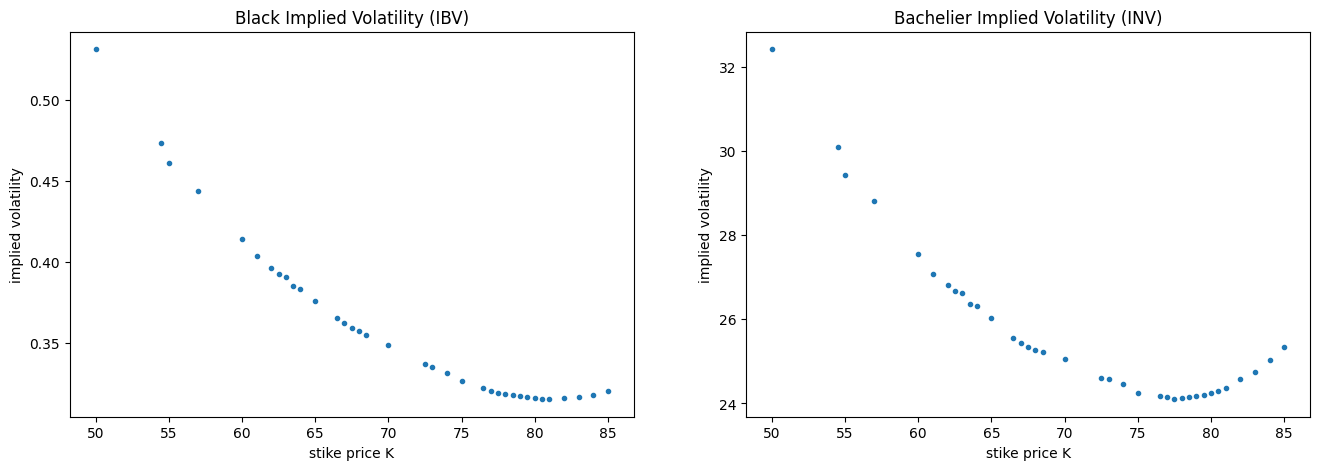

In [26]:
# IBV and IMV
list_ibv_mkt, list_inv_mkt  = [], []
for strike_, price_, option_type_ in zip(df_data.index, df_data.loc[:,'price'], df_data.loc[:,'option type']):
  list_ibv_mkt.append(implied_volatility(price_, futures_price, strike_, risk_free_rate, time_to_maturity,
                                                          option_type = option_type_, model = 'black', method='brent', disp=False))
  list_inv_mkt.append(implied_volatility(price_, futures_price, strike_, risk_free_rate, time_to_maturity,
                                                          option_type = option_type_, model = 'bachelier', method='brent', disp=False))

# create subplots
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(df_data.index, list_ibv_mkt, '.')
ax1.set_title('Black Implied Volatility (IBV)')
ax1.set_xlabel('stike price K')
ax1.set_ylabel('implied volatility')

ax2 = fig.add_subplot(122)
ax2.plot(df_data.index, list_inv_mkt, '.')
ax2.set_title('Bachelier Implied Volatility (INV)')
ax2.set_xlabel('stike price K')
ax2.set_ylabel('implied volatility')

plt.show()

### Calibration Scheme
$$ argmin_{\theta}\sum_{i=1}^{N}\biggl( P_i(K_i) - f(K_i|\Theta) \biggr)^2 $$

In [27]:
# calibration
def qnm_option_pricer(arr_K, a, b, c):
  list_price, qnm_ = [], QNM(futures_price, a, b, c, risk_free_rate, time_to_maturity)
  for K_ in arr_K:
    if K_ < futures_price:
      list_price.append(qnm_.option_pricer(K = K_, option_type = 'put'))
    else:
      list_price.append(qnm_.option_pricer(K = K_, option_type = 'call'))
  return list_price

params, _ = curve_fit(qnm_option_pricer, df_data.index, df_data.loc[:,'price']
                      , p0=[a, b, c], bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))

In [28]:
qnm_calibration = QNM(futures_price, params[0], params[1], params[2], risk_free_rate, time_to_maturity)
arr_qnm_call = qnm_calibration.option_pricer(K = df_data.index, option_type = 'call')

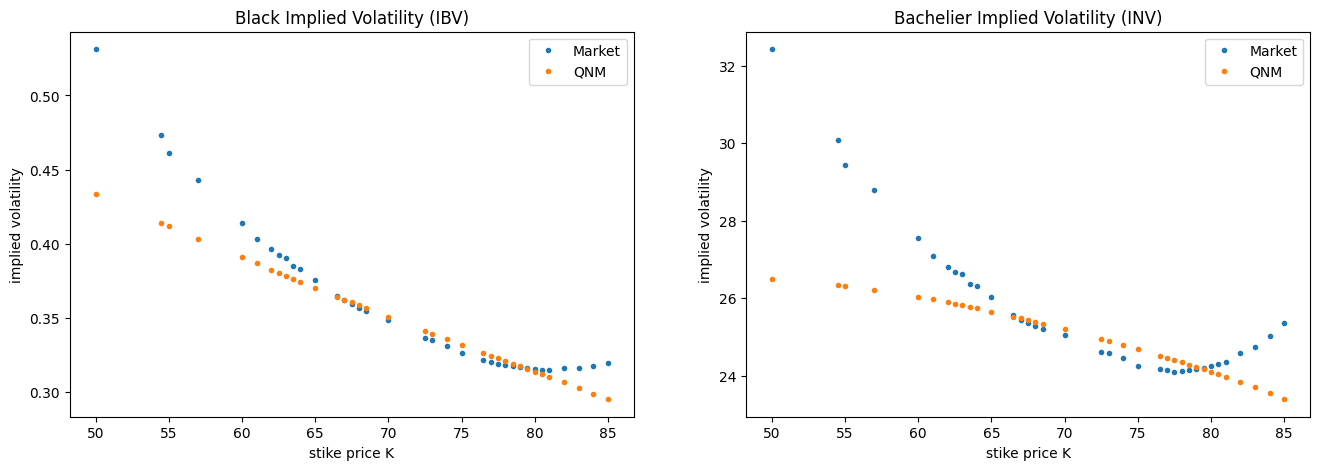

In [29]:
# IBV and IMV
list_ibv_qnm, list_inv_qnm = [], []
for strike_, price_ in zip(df_data.index, arr_qnm_call):
  list_ibv_qnm.append(implied_volatility(price_, futures_price, strike_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=False))
  list_inv_qnm.append(implied_volatility(price_, futures_price, strike_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=False))

# create subplots
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(df_data.index, list_ibv_mkt, '.', label = 'Market')
ax1.plot(df_data.index, list_ibv_qnm, '.', label = 'QNM')
ax1.set_title('Black Implied Volatility (IBV)')
ax1.set_xlabel('stike price K')
ax1.set_ylabel('implied volatility')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(122)
ax2.plot(df_data.index, list_inv_mkt, '.', label = 'Market')
ax2.plot(df_data.index, list_inv_qnm, '.', label = 'QNM')
ax2.set_title('Bachelier Implied Volatility (INV)')
ax2.set_xlabel('stike price K')
ax2.set_ylabel('implied volatility')
ax2.legend(loc='upper right')

plt.show()

## Technicle note - Quadratic Normal Model

Consider an underlying futures price, $F_t$, with the following dynamics:

\begin{cases}
dF_t = \sigma(F_t)dW_t \\
\sigma(F_t) = a + \epsilon(F_t)
\end{cases}

Here, $\epsilon$ represents a small perturbation that only depends on the space $F$.

Under the no-arbitrage condition, any derivative price $V(F, t)$ in this economy satisfies the following partial differential equation (PDE):

\begin{align*}
& \frac{\partial V}{\partial t} + \frac{(a + \epsilon)^2}{2}\frac{\partial^2 V}{\partial F^2} = rV\\
\end{align*}

We are specifically interested in the European call option price, $C(F, t)$. We conjecture that $C = C_{BC} + e^{-r(T-t)}U$, where $C_{BC}$ is the Bachelier call formula. Substituting this into the above PDE, we obtain:

\begin{align*}
(\frac{\partial C_{BC}}{\partial t} + \frac{a^2}{2}\frac{\partial^2 C_{BC}}{\partial F^2} - rC_{BC}) + e^{-r(T-t)}(\frac{\partial U}{\partial t} + \frac{a^2}{2}\frac{\partial^2 U}{\partial F^2} + a\epsilon\frac{\partial^2 C_{BC}e^{r(T-t)}}{\partial F^2}) + e^{-r(T-t)}(\frac{\epsilon^2}{2}\frac{\partial^2 C_{BC}e^{r(T-t)}}{\partial F^2} + (a\epsilon + \frac{\epsilon^2}{2})\frac{\partial^2 U}{\partial F^2}) = 0
\end{align*}

The Bachelier formula $C_{BC}$ solves the first parenthesis. The terms grouped in the last parenthesis are of higher order with respect to $\epsilon$. Therefore, any $U$ satisfying the second parenthesis makes the PDE hold for some small perturbation $\epsilon$. Let's consider $\tau = T-t$ and $U = \sqrt{\tau}n\left(\frac{F-K}{a\sqrt{\tau}}\right)p(F, \tau)$. After changes of variables, the PDE is now transformed into the following:

\begin{align*}
p + \tau \frac{\partial p}{\partial t} - \frac{a\tau}{2}\frac{\partial^2 p}{\partial F^2} + (F-K)\frac{\partial p}{\partial F} = \epsilon
\end{align*}

Let $\epsilon(F) = bF+cF^2$ and $p(F, \tau) = w_0 + w_1F + w_2F^2 + w_3\tau$. The PDE relates these two functions through a set of linear equations:

\begin{cases}
w_0 - Kw_1 = 0 \\
2w_1 - 2Kw_2 = b \\
3w_2 = c \\
2w_3 = a^2w_2
\end{cases}

The solution to the above linear system is:
\begin{cases}
w_0 = \frac{Kb}{2} + \frac{K^2c}{3}\\
w_1 = \frac{b}{2} + \frac{Kc}{3}\\
w_2 = \frac{c}{3}\\
w_3 = \frac{a^2c}{6}
\end{cases}

This method can be extended to accommodate higher-order polynomial volatility perturbation functions $\epsilon(F)$. In such cases, $p(F, \tau)$ should also be considered as a polynomial of the same order, with coefficients determined by matching the corresponding terms to ensure the satisfaction of the PDE.